# Model 2: Deep Learning

## Importing Libraries

In [14]:
%pip install pydot graphviz

import os
import h5py
import numpy as np
import pandas as pd
import pyarrow as pa
import tensorflow as tf
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Add, Input

Note: you may need to restart the kernel to use updated packages.


## Disable Warnings

In [15]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

## Load the Dataset

In [16]:
def read_file(path):
  chunk_size = 25

# Create a Parquet file reader object
  parquet_file = pq.ParquetFile(path)

# Determine the total number of rows in the file
  total_rows = parquet_file.metadata.num_rows

# Loop over the file in chunks
  data = []
  for i in range(0, total_rows, chunk_size):
    # Read a chunk of rows from the file
      chunk = (parquet_file.read_row_group(i))
      dm = (chunk.to_pandas())
      data.append(dm)

# Concatenate all the DataFrames into a single DataFrame
  df = pd.concat(data, ignore_index=True)
  print(parquet_file.read_row_group(0).to_pandas())
  return df

In [17]:
df1 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run0.test.snappy.parquet')
df2 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run1.test.snappy.parquet')
df3 = read_file('/kaggle/input/common-task-2-dataset/Task - 2 Data (Parquet)/jet0_run2.test.snappy.parquet')

                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  112.411095  21.098248   

     y  
0  0.0  
                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  147.686737  32.114449   

     y  
0  0.0  
                                              X_jets          pt         m0  \
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  107.854118  18.723455   

     y  
0  0.0  


## Constructing X and y

In [18]:
def construct_X_y(df):
    # Get the total number of samples
    num_samples = len(df)

    # Initialize empty arrays for X and y
    X = np.empty((num_samples, 3, 125, 125), dtype=np.float32)
    y = np.empty(num_samples, dtype=int)

    # Iterate through the DataFrame and fill X and y
    for i, row in df.iterrows():
        # Stack the three channels of X_jets and transpose them to match the desired shape
        X[i] = np.transpose(np.dstack((np.stack(row['X_jets'][0]), np.stack(row['X_jets'][1]), np.stack(row['X_jets'][2]))), (2, 0, 1))
        # Assign the label to y
        y[i] = row['y']

    # Rearrange the dimensions of X to match the TensorFlow format (samples, height, width, channels)
    X = np.transpose(X, (0, 2, 3, 1))

    return X, y

In [19]:
# Assuming 'df' is the pandas DataFrame
X1, y1 = construct_X_y(df1)
X2, y2 = construct_X_y(df2)
X3, y3 = construct_X_y(df3)

In [20]:
# Save X1 array to binary file 'X1.npy'
with open('X1.npy', 'wb') as f:
    np.save(f, X1)

# Save y1 array to binary file 'y1.npy'
with open('y1.npy', 'wb') as f:
    np.save(f, y1)

# Save X2 array to binary file 'X2.npy'
with open('X2.npy', 'wb') as f:
    np.save(f, X2)

# Save y2 array to binary file 'y2.npy'
with open('y2.npy', 'wb') as f:
    np.save(f, y2)

# Save X3 array to binary file 'X3.npy'
with open('X3.npy', 'wb') as f:
    np.save(f, X3)

# Save y3 array to binary file 'y3.npy'
with open('y3.npy', 'wb') as f:
    np.save(f, y3)

In [21]:
x1 = np.load('X1.npy')
x2 = np.load('X2.npy')
x3 = np.load('X3.npy')

y1 = np.load('y1.npy')
y2 = np.load('y2.npy')
y3 = np.load('y3.npy')

In [22]:
# Combine x arrays along the first axis (axis=0)
x = np.concatenate((x1, x2, x3), axis=0)

# Combine y arrays along the first axis (axis=0)
y = np.concatenate((y1, y2, y3), axis=0)

# Save the combined X array to a binary file named 'X.npy'
with open('x.npy', 'wb') as f:
    np.save(f, x)

# Save the combined y array to a binary file named 'y.npy'
with open('y.npy', 'wb') as f:
    np.save(f, y)

In [23]:
# Loading the content of x.npy into the variable x
x = np.load('x.npy')

# Loading the content of y.npy into the variable y
y = np.load('y.npy')

## CNN Model Creation

In [24]:
model = Sequential()

# Add the first convolutional layer with 125 filters, each with a 3x3 kernel, ReLU activation, and input shape of (125, 125, 3)
model.add(Conv2D(125, (3, 3), activation='relu', input_shape=(125, 125, 3)))

# Add BatchNormalization layer
model.add(BatchNormalization())

# Add MaxPooling layer with pool size (2, 2)
model.add(MaxPooling2D((2, 2)))

# Add Dropout layer with a dropout rate of 0.25
model.add(Dropout(0.25))

# Add the second convolutional layer with 64 filters and a 3x3 kernel, ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add BatchNormalization layer
model.add(BatchNormalization())

# Add MaxPooling layer with pool size (2, 2)
model.add(MaxPooling2D((2, 2)))

# Add Dropout layer with a dropout rate of 0.25
model.add(Dropout(0.25))

# Add the third convolutional layer with 128 filters and a 3x3 kernel, ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add BatchNormalization layer
model.add(BatchNormalization())

# Add MaxPooling layer with pool size (2, 2)
model.add(MaxPooling2D((2, 2)))

# Add Dropout layer with a dropout rate of 0.25
model.add(Dropout(0.25))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add a fully connected Dense layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))

# Add BatchNormalization layer
model.add(BatchNormalization())

# Add Dropout layer with a dropout rate of 0.5
model.add(Dropout(0.5))

# Add output layer with 1 unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Define the optimizer (Adam) with a learning rate of 1e-3
optimizer = Adam(learning_rate=1e-3)

# Compile the model with binary crossentropy loss and accuracy metric
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 123, 123, 125)  │         3,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 123, 123, 125)  │           500 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 61, 125)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 61, 61, 125)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 59, 59, 64)     │        72,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,920,353 (11.14 MB)

 Trainable params: 2,919,463 (11.14 MB)

 Non-trainable params: 890 (3.48 KB)

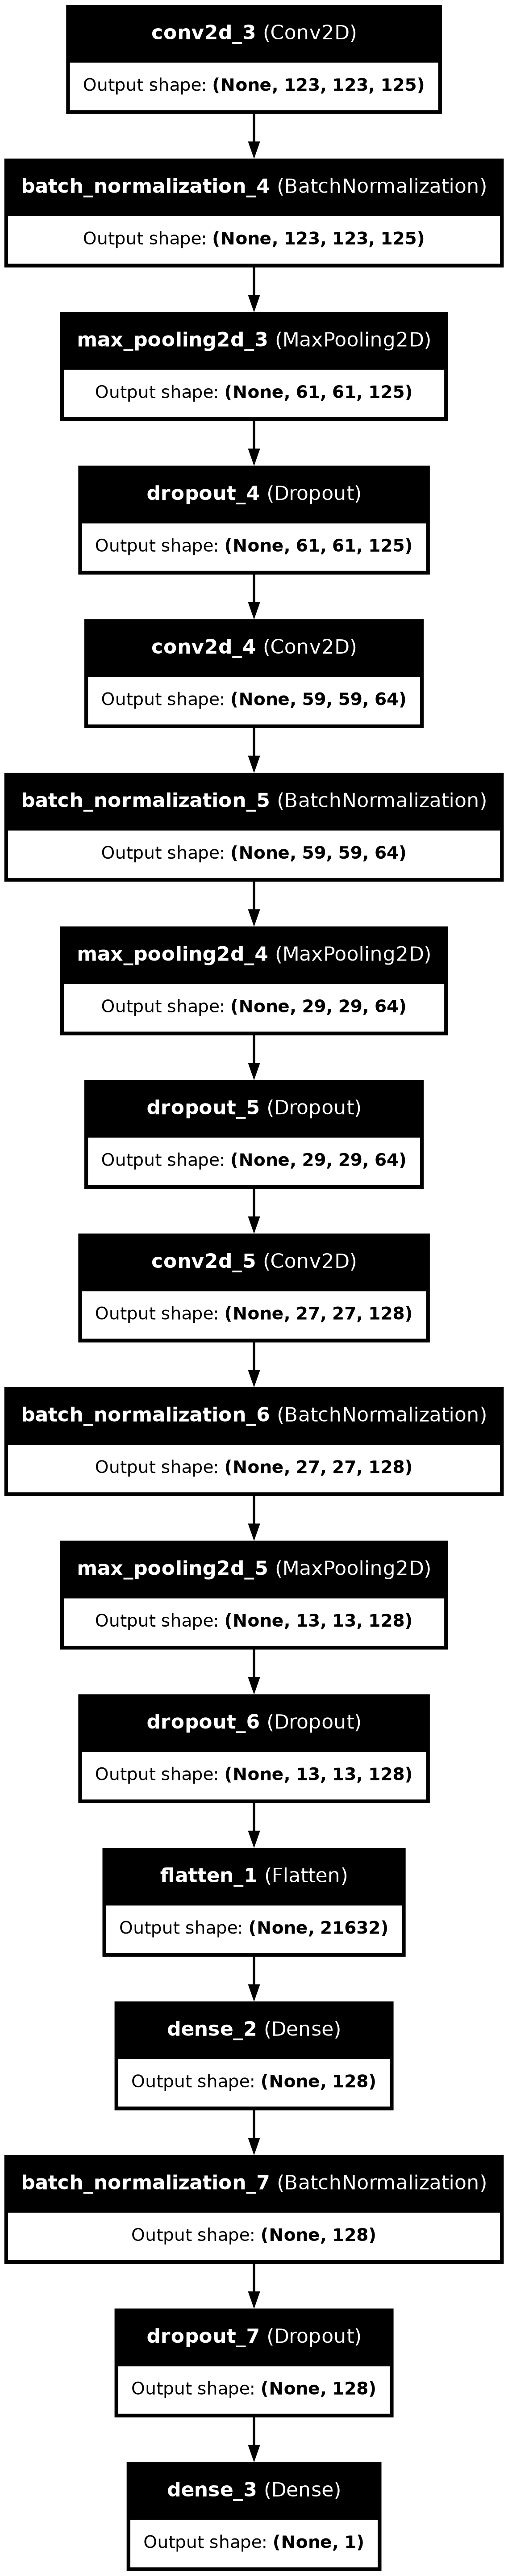

In [26]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Data Splitting

In [27]:
xtrain, xtest, ytrain, ytest = train_test_split(x,
                                               y,
                                               test_size = 0.2,
                                               random_state = 42)

## Model Training

In [28]:
history = model.fit(xtrain, 
                    ytrain, 
                    epochs=5, 
                    batch_size=8, 
                    validation_split=0.1, 
                    verbose=1)

Epoch 1/5
 18/502 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5001 - loss: 1.1507  

I0000 00:00:1711460708.126313     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711460708.151509     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


502/502 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5789 - loss: 0.8574

W0000 00:00:1711460721.997410     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


502/502 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.5789 - loss: 0.8573 - val_accuracy: 0.6256 - val_loss: 0.6370
Epoch 2/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6462 - loss: 0.6598 - val_accuracy: 0.6323 - val_loss: 0.6256
Epoch 3/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6784 - loss: 0.6252 - val_accuracy: 0.6816 - val_loss: 0.6074
Epoch 4/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6633 - loss: 0.6194 - val_accuracy: 0.6682 - val_loss: 0.6222
Epoch 5/5
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7023 - loss: 0.5821 - val_accuracy: 0.6614 - val_loss: 0.6293


### Prediction Probability

In [29]:
y_pred_probs = model.predict(xtest)

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


### ROC-AUC Score

In [30]:
roc_auc = roc_auc_score(ytest, y_pred_probs)
print(f'ROC AUC score: {roc_auc}')

ROC AUC score: 0.757904132188797


In [31]:
# Calculate the false positive rate (false_pr), true positive rate (true_pr), and thresholds
false_pr, true_pr, thresholds = roc_curve(ytest, y_pred_probs)

### Calculate the ROC-AUC Scores

In [32]:
roc_auc = auc(false_pr, true_pr)

## Plotting ROC-AUC Curve

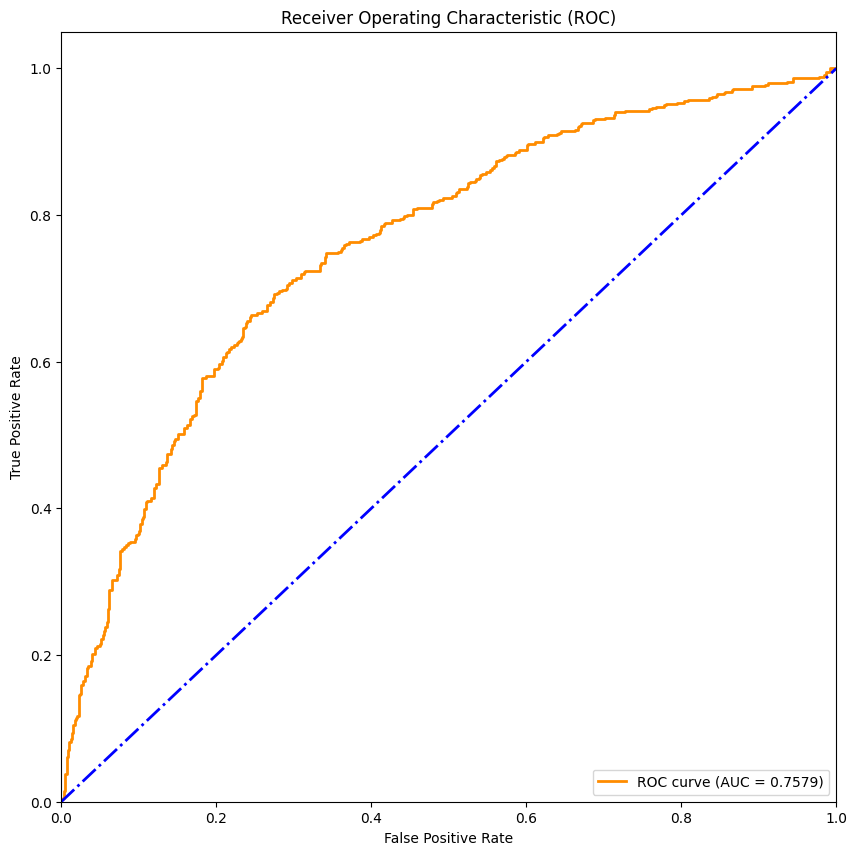

In [33]:
plt.figure(figsize = (10, 10))
lw = 2
plt.plot(false_pr, true_pr, color='darkorange', lw=lw, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()